В Hugging Face в качестве подходящей для идентификации языков с кириллицей была выбрана модель "SebOchs/canine-c-lang-id", которая умеет распознавать 223 языка, в том числе многие из входящих в датасет. По описанию качество модели следующее:

* Accuracy: 94,92%
* Macro F1-score: 94,91%

Попробовать работу модели на своем датасете пока получилось только в цикле по одному экземпляру, так как метки языков не совпадают, нужен маппер, но осложняется все тем, что есть языки, которые присутствуют либо только в модели, либо только в датасете. Поэтому нужно как-то решить, что делать с отсутствующими языками. Оставил это на следующую итерацию.

Кроме того, дообучить эту модель тоже пока не удалось. Хоть Trainer и заработал - спасибо за подсказку - но ему не хватило памяти в Colab при работе на GPU. 
В итоге дообучить пришлось другую модель.

По данной модели построена матрица ошибок по предсказаниям на наборе из 2000 данных. В целом для универсальной модели результат неплохой, много ошибок соответствуют отстутствующим языкам.



In [21]:
from transformers import pipeline
from datasets import load_from_disk
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model = AutoModelForSequenceClassification.from_pretrained("SebOchs/canine-c-lang-id")

In [2]:
!pip install pycountry
import datasets
import pycountry
def int_to_lang():
    dataset = datasets.load_dataset('wili_2018')
    # names for languages not in iso-639-3 from wikipedia
    non_iso_languages = {'roa-tara': 'Tarantino', 'zh-yue': 'Cantonese', 'map-bms': 'Banyumasan',
                         'nds-nl': 'Dutch Low Saxon', 'be-tarask': 'Belarusian'}
    # create dictionary from data set labels to language names
    lab_to_lang = {}
    for i, lang in enumerate(dataset['train'].features['label'].names):
        full_lang = pycountry.languages.get(alpha_3=lang)
        if full_lang:
            lab_to_lang[i] = full_lang.name
        else:
            lab_to_lang[i] = non_iso_languages[lang]
    return lab_to_lang

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 15.0 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=b160385dda6be13ad224d5a6ed62ba42b2a0dda58e2cf00656855f8feda57edf
  Stored in directory: /home/stud/.cache/pip/wheels/47/15/92/e6dc85fcb0686c82e1edbcfdf80cfe4808c058813fed0baa8f
Successfully built pycountry


In [7]:
#!unzip lid.zip
ds = load_from_disk('lid')

In [8]:
langs = ds['test'].features['label'].names

In [9]:
id2label = {idx: langs[idx] for idx in range(len(langs))}
label2id = {v: k for k, v in id2label.items()}

In [54]:
test = ds['test'].select(range(2000))

In [55]:
test

Dataset({
    features: ['label', 'text'],
    num_rows: 2000
})

In [ ]:
y_test, y_pred = [],[]
count = 0
with torch.no_grad():
    for lang, text in zip(test['label'], test['text']):
        input_ids = torch.tensor([[ord(char) for char in text]])
        outputs = model(input_ids)
        pred = lab_to_lang[torch.argmax(outputs.logits).item()]
        y_test.append(id2label[lang])
        y_pred.append(pred)

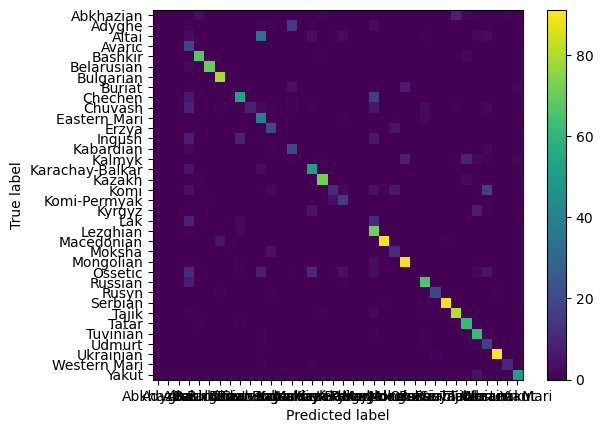

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=langs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=langs)
disp.plot(include_values=False)
plt.show()

In [63]:
mapper = {}
for k,v in lab_to_lang.items():
    if v in label2id:
        mapper[label2id[v]] = k
mapper

{27: 5,
 13: 22,
 29: 23,
 26: 24,
 3: 28,
 32: 35,
 9: 47,
 22: 64,
 6: 66,
 28: 97,
 33: 104,
 16: 118,
 15: 122,
 5: 208,
 10: 130,
 8: 131,
 18: 132,
 4: 136,
 31: 143,
 23: 166,
 21: 184,
 34: 187,
 35: 199,
 24: 213,
 30: 225,
 11: 226,
 17: 229}

In [64]:
lang2lab = {v:k for k,v in lab_to_lang.items()}

TODO: Доделать маппер и прогнать модель в пакетном режиме с подсчетом accuracy